In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 08b

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset
- use of datasets

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

2024-11-15 19:09:45.001335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731677985.014356   62680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731677985.018218   62680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 19:09:45.033914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 256

TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [5]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [9]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [11]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [12]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [13]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

In [14]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [15]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [16]:
type(X_train), type(X_test), type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Converting to Datasets

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

I0000 00:00:1731677986.918618   62680 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4175 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [18]:
type(train_ds)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

### Preprocessing and Batching

Apply various transformations, such as shuffling and batching, to the dataset:

In [19]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [20]:
## Optimize for performance
# Cache the data to avoid redundant processing
# Repeat the dataset for multiple epochs
# Prefetch data to overlap preprocessing and model execution:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
next(iter(train_ds))

2024-11-15 19:09:49.257720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(256, 33), dtype=float64, numpy=
 array([[-1.40940648, -2.37242944, -2.22160236, ...,  2.2335296 ,
          2.50974981,  2.41343878],
        [ 1.04881658,  0.96385295, -1.27004689, ..., -0.19532294,
         -0.43407708, -0.03964503],
        [ 0.94639062, -1.16446513,  0.08931806, ..., -0.19532294,
         -0.66958323, -0.59716408],
        ...,
        [-0.74363774, -0.9918988 ,  0.97290528, ..., -0.62037214,
         -0.43407708, -0.20690075],
        [-0.89727668,  0.56119818,  0.4291593 , ..., -0.13460163,
         -0.25744747, -0.59716408],
        [ 0.9976036 ,  0.44615396,  0.90493703, ..., -0.25604426,
         -0.19857093, -0.59716408]])>,
 <tf.Tensor: shape=(256,), dtype=int8, numpy=
 array([0, 3, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 3, 2, 0, 1, 0, 2, 2, 2, 0, 1,
        3, 3, 2, 3, 3, 3, 0, 2, 0, 2, 2, 1, 3, 3, 0, 2, 1, 1, 0, 0, 2, 3,
        2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 3, 2, 3, 1,
        2, 3, 0, 2, 1, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2,

In [22]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(256, 33) (256,)


2024-11-15 19:09:49.908332: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-15 19:09:49.910312: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Prepare model

### Functional API

<p style="font-family: Arial; font-size:1.2em;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

In [23]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

outputs = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [24]:
predictions = model(features).numpy()
predictions.shape

(256, 4)

In [25]:
predictions[0].sum()

np.float32(-1.1651509)

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [26]:
tf.nn.softmax(predictions).numpy()[0]

array([0.08768044, 0.85272586, 0.02440719, 0.03518647], dtype=float32)

In [27]:
tf.nn.softmax(predictions).numpy().sum(axis = 1)[0]

np.float32(1.0)

In [28]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [30]:
labels

<tf.Tensor: shape=(256,), dtype=int8, numpy=
array([1, 3, 1, 1, 1, 2, 2, 0, 3, 1, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 2, 3,
       2, 0, 1, 2, 3, 1, 1, 2, 1, 2, 3, 2, 2, 3, 0, 2, 1, 1, 1, 2, 2, 3,
       2, 2, 2, 2, 3, 0, 2, 3, 1, 2, 0, 2, 2, 1, 1, 3, 1, 2, 3, 1, 2, 2,
       1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 1, 3, 1, 2, 3, 3, 2,
       2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 3, 0, 2, 0, 1, 1, 1, 1, 1,
       1, 2, 3, 1, 2, 3, 2, 3, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 1,
       2, 1, 0, 0, 0, 3, 2, 2, 3, 0, 1, 1, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 3, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 3, 3, 1,
       2, 1, 2, 2, 3, 1, 1, 3, 2, 0, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 3,
       3, 2, 3, 1, 2, 1, 3, 1, 0, 2, 1, 2, 2, 0, 2, 0, 3, 2, 2, 1, 1, 1,
       3, 1, 3, 2, 1, 1, 2, 1, 2, 1, 3, 2, 3, 2], dtype=int8)>

In [31]:
loss_fn(labels, predictions).numpy()

np.float32(2.0166962)

Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer
- List of metrics to monitor

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

Call `fit()`, which will train the model by slicing the data into `batches` of size `batch_size`, and repeatedly iterating over the entire dataset for a given number of `epochs`. Pass some validation for monitoring validation loss and metrics at the end of each epoch.

In [33]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/100


I0000 00:00:1731678006.978551   62762 service.cc:148] XLA service 0x772f74003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731678006.978596   62762 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-15 19:10:06.990762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731678007.032697   62762 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1814 - loss: 1.9683

I0000 00:00:1731678007.878154   62762 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2852 - loss: 1.6133 - val_accuracy: 0.6369 - val_loss: 0.8576
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6968 - loss: 0.7721 - val_accuracy: 0.7777 - val_loss: 0.5765
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.7922 - loss: 0.5441 - val_accuracy: 0.8028 - val_loss: 0.4806
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.8167 - loss: 0.4604 - val_accuracy: 0.8193 - val_loss: 0.4328
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.8340 - loss: 0.4164 - val_accuracy: 0.8262 - val_loss: 0.4014
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8443 - loss: 0.3866 - val_accuracy: 0.8410 - val_loss: 0.3789
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.8520 - loss: 0.3658 - val_accuracy: 0.8463 - val_loss: 0.3623
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8575 - loss: 0.3503 - val_accuracy: 0.8482 - 

In case we want to separately evaluate this model, we have `evaluate` function.

In [34]:
model.evaluate ( test_ds, verbose=2)

15/15 - 0s - 881us/step - accuracy: 0.8766 - loss: 0.2943


[0.29431354999542236, 0.876583993434906]

In [35]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.405249,1.311170,0.636915,0.857625
1,0.736585,0.693422,0.777686,0.576549
2,0.799545,0.515164,0.802755,0.480607
3,0.820142,0.444207,0.819284,0.432806
4,0.835641,0.404169,0.826171,0.401425


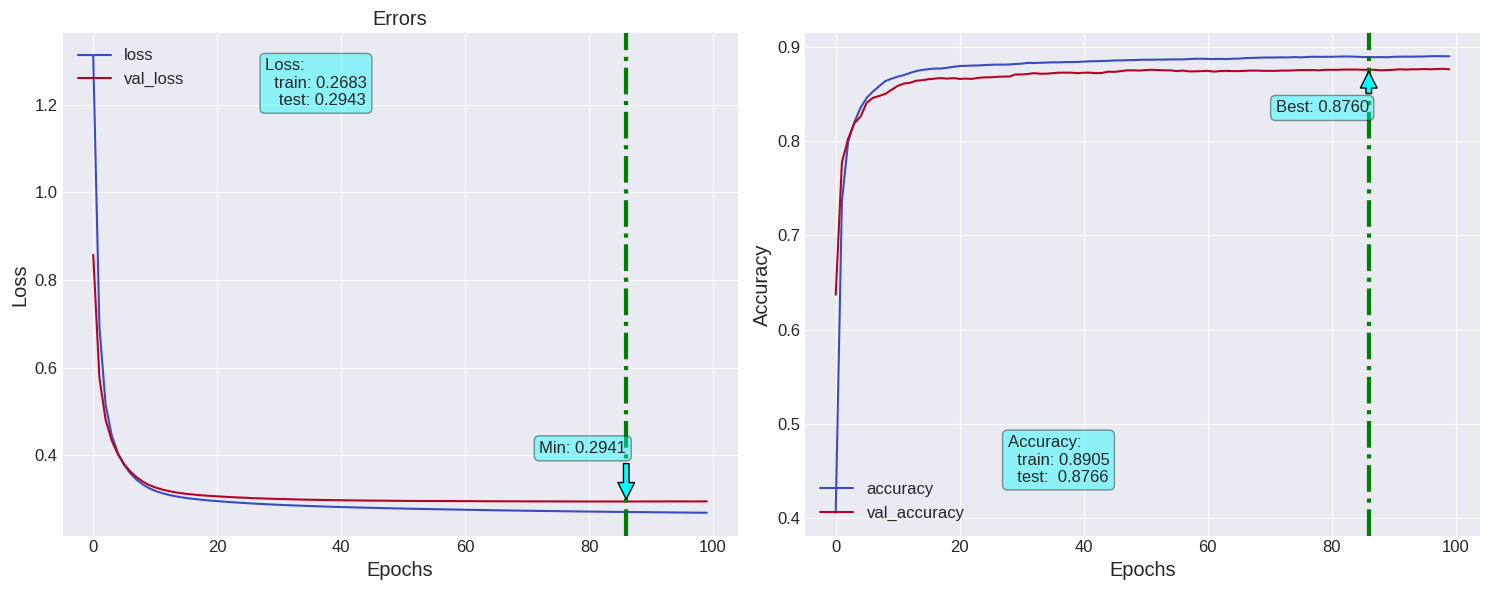

In [36]:
fn_plot_tf_hist(loss_df)

In [37]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
86,0.889578,0.270124,0.876033,0.294055


## Predictions

In [38]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [39]:
y_true, y_pred = [],[]
for feats, lbls in train_ds:
    pred = probability_model(feats).numpy()
    pred = pred.argmax(axis =1)
    y_pred.extend(pred)
    y_true.extend(lbls)
len(y_pred), len(y_true)

2024-11-15 19:10:31.264111: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(14517, 14517)

In [40]:
print(classification_report( y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.87      0.78      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [43]:
y_true, y_pred = [],[]
for feats, lbls in test_ds:
    pred = probability_model(feats).numpy()
    pred = pred.argmax(axis =1)
    y_pred.extend(pred)
    y_true.extend(lbls)

len(y_pred), len(y_true)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_true, y_pred)))

Accuracy score on Test Data :0.87658


2024-11-15 19:11:39.573795: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.87      0.84      1368
           3       0.84      0.74      0.79       684

    accuracy                           0.88      3630
   macro avg       0.90      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



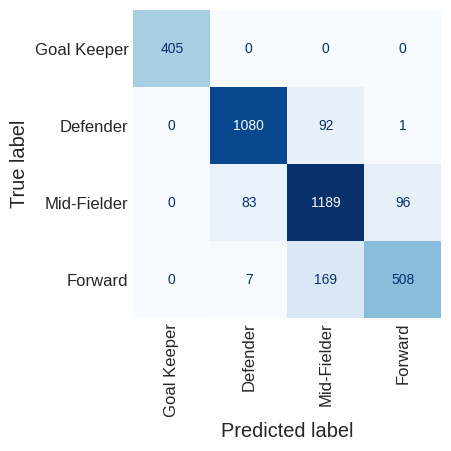

In [45]:
fn_plot_confusion_matrix( y_true, y_pred, labels=class_labels)